In [2]:
!pip install opendatasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import pandas
  
od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?resource=download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manavbaldewa
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:21<00:00, 37.1MB/s]


In [36]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
from torchsummary import summary

from PIL import Image
from matplotlib import pyplot as plt

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.0.0+cu118


In [22]:
class_names = ['Normal', 'Viral Pneumonia', 'COVID']
root_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c+"/images")) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c+"/images", image)
            target_path = os.path.join(root_dir, 'test', , image)
            shutil.move(source_path, target_path)

In [23]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Normal', 'Viral Pneumonia', 'COVID']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [24]:
train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.Resize(size=(224, 224)),
                  torchvision.transforms.RandomHorizontalFlip(),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
                 torchvision.transforms.Resize(size=(224, 224)),
                 torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [26]:
train_dirs = {
    'Normal': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images',
    'Viral Pneumonia': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'COVID': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 Normal examples
Found 1315 Viral Pneumonia examples
Found 3586 COVID examples


In [27]:
test_dirs = {
    'Normal': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/test/Normal',
    'Viral Pneumonia': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/test/Viral Pneumonia',
    'COVID': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/test/COVID'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 Normal examples
Found 30 Viral Pneumonia examples
Found 30 COVID examples


In [43]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2511
Number of test batches 15


In [44]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

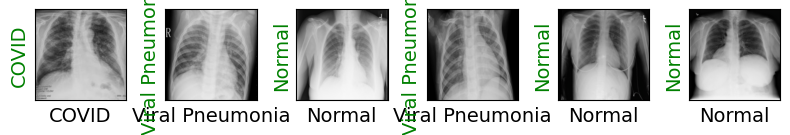

In [45]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

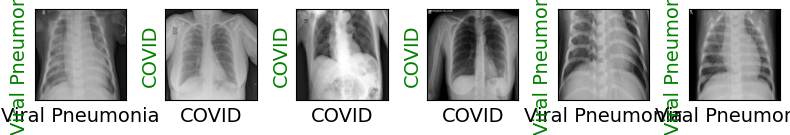

In [46]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [47]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [49]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

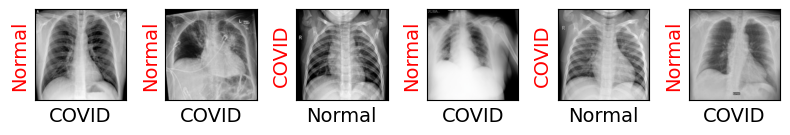

In [50]:
show_preds()

In [51]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                acc = 0.
               

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                acc = acc/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {acc:.4f}')

                show_preds()

                resnet18.train()

                if acc >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1265, Accuracy: 0.4444


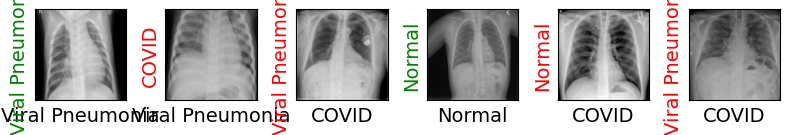

Evaluating at step 20
Validation Loss: 0.9153, Accuracy: 0.6556


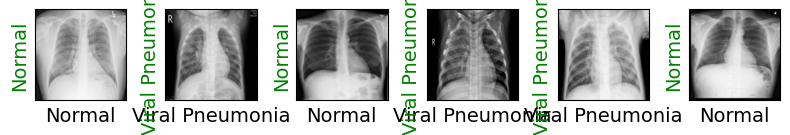

Evaluating at step 40
Validation Loss: 0.6064, Accuracy: 0.8667


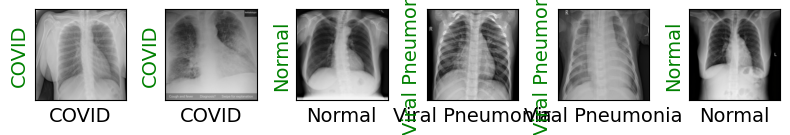

Evaluating at step 60
Validation Loss: 0.4164, Accuracy: 0.8889


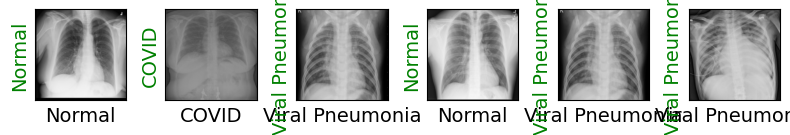

Evaluating at step 80
Validation Loss: 0.3391, Accuracy: 0.9333


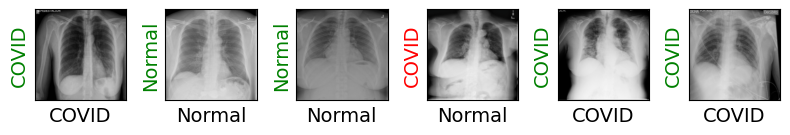

Evaluating at step 100
Validation Loss: 0.3161, Accuracy: 0.9000


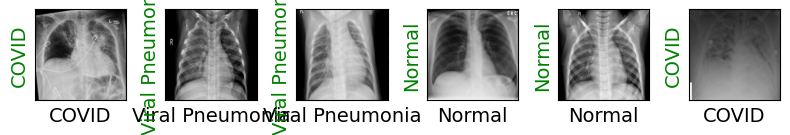

Evaluating at step 120
Validation Loss: 0.2882, Accuracy: 0.9333


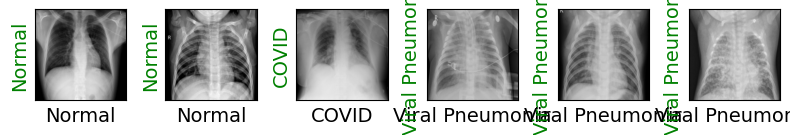

Evaluating at step 140
Validation Loss: 0.3266, Accuracy: 0.9000


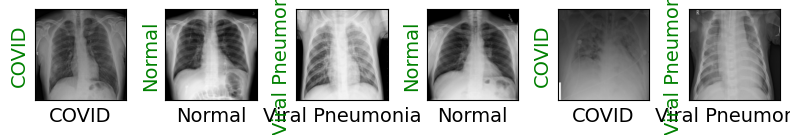

Evaluating at step 160
Validation Loss: 0.3017, Accuracy: 0.8778


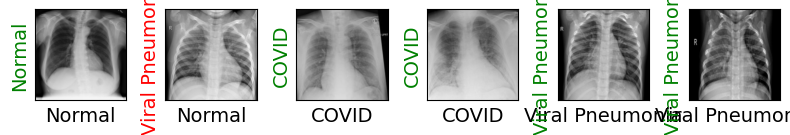

Evaluating at step 180
Validation Loss: 0.2557, Accuracy: 0.8889


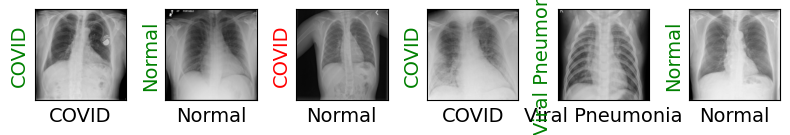

Evaluating at step 200
Validation Loss: 0.2142, Accuracy: 0.9111


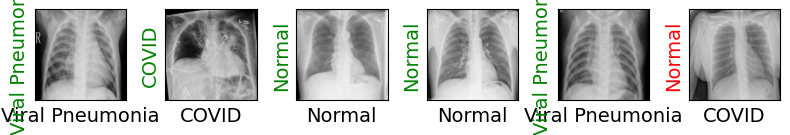

Evaluating at step 220
Validation Loss: 0.2021, Accuracy: 0.9333


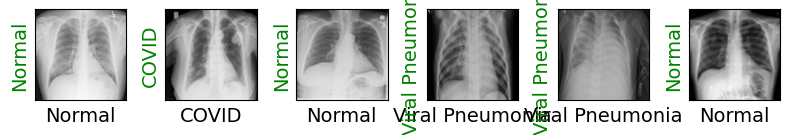

Evaluating at step 240
Validation Loss: 0.1758, Accuracy: 0.9778


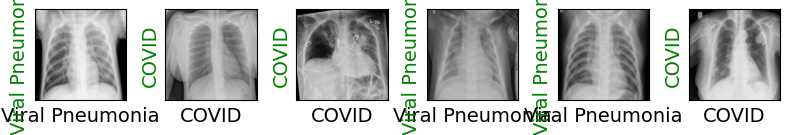

Performance condition satisfied, stopping..
CPU times: user 8min 44s, sys: 12.5 s, total: 8min 57s
Wall time: 9min 2s


In [52]:
%%time

train(epochs=1)

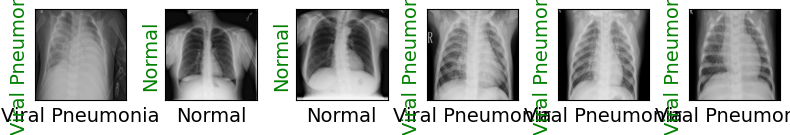

In [53]:
show_preds()